In [9]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, TextVectorization
import re
import pickle
from sklearn.model_selection import train_test_split
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
IMAGES_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
CAPTIONS_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

In [11]:
SEQ_LEN = 24
VOCAB_SIZE = 13000

In [12]:
def load_captions(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:]
        caption_mapping = {}
        text_data = []
        image_to_skip = set()
        for line in caption_data:
            line = line.rstrip('\n')

            try:
                img_name, _, caption = line.split('|')
            except ValueError:
                img_name, caption = line.split('|')
                caption = caption[4:] 
            img_name = os.path.join(IMAGES_PATH,img_name.strip())

            tokens = caption.strip().split()
            if len(tokens)<4 or len(tokens)>SEQ_LEN:
                image_to_skip.add(img_name)
                continue
            if img_name.endswith('jpg') and img_name not in image_to_skip:
                caption = "<start>" + caption.strip() + "<end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]
        for img_name in image_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]
        return caption_mapping, text_data


In [13]:
def train_val_split(caption_data,validation_size=0.2,test_size=0.02,shuffle=True):
    all_images = list(caption_data.keys())
    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)
    
    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}
    return training_data, validation_data, test_data
    

In [14]:
caption_mapping, text_data = load_captions(CAPTIONS_PATH)

train_data, validation_data, test_data = train_val_split(caption_mapping)
print(len(caption_mapping))
print(len(train_data))
print(len(test_data))
print(len(validation_data))

26144
20915
105
5124


In [15]:
def custom_standardization(input_str):
    lowercase = tf.strings.lower(input_str)
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890"
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [16]:
vectorization = TextVectorization(max_tokens=VOCAB_SIZE,output_mode='int',output_sequence_length=SEQ_LEN,standardize=custom_standardization)
vectorization.adapt(text_data)

image_argumentation = tf.keras.Sequential([layers.RandomFlip('horizantle'),layers.RandomRotation(0.2),layers.RandomContrast(0.3)])
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1],text_data))

In [17]:
# os.makedirs('/kaggle/working/models', exist_ok=True)
# model = tf.keras.Sequential([vectorization])
# model.save('/kaggle/working/models/text_vectorization_model')

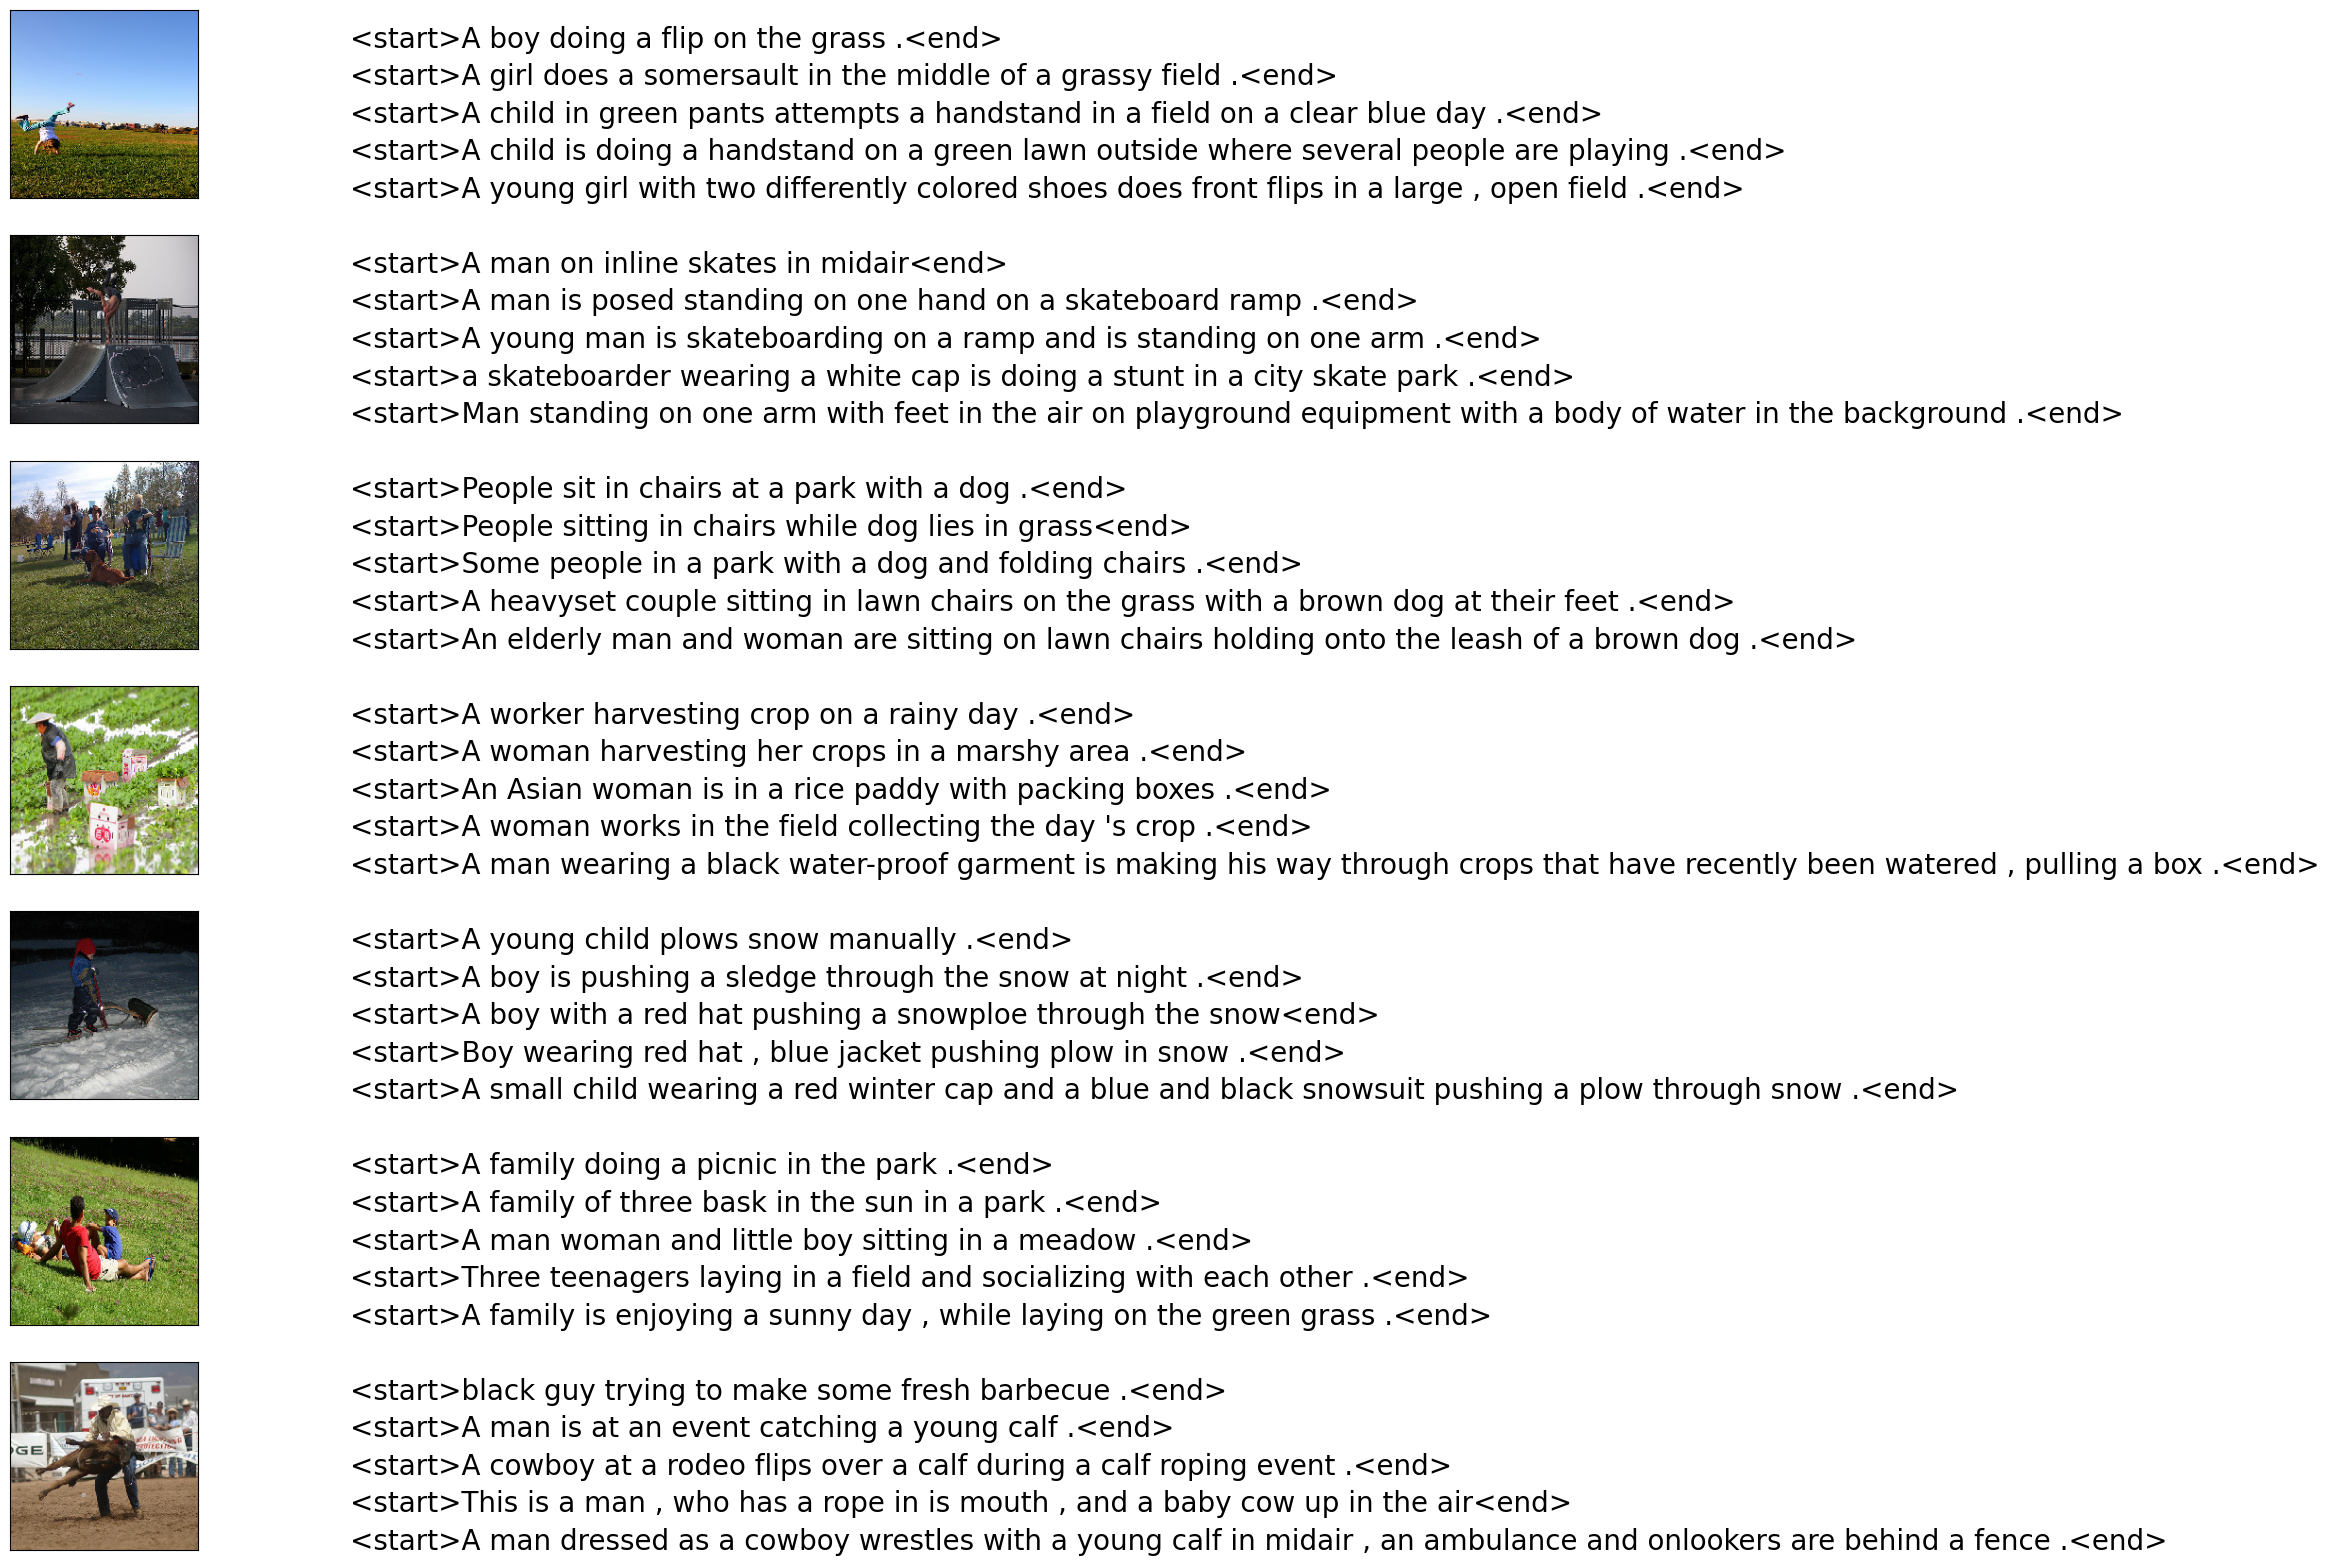

In [20]:
import matplotlib.pyplot as plt
def visualaization(data, num_of_images):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(data.keys())[154:154+num_of_images]:
        captions = data[filename]
        image_load = load_img(filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(train_data, 7)

In [21]:
IMAGE_SIZE = (255,255)
EMBED_DIM = 512
FF_DIM = 512
BATCH_SIZE = 256
EPOCHS = 100

In [22]:
def decode_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img,tf.float32)
    return img

def process_input(img_path, captions):
    return decode_resize(img_path), vectorization(captions)

In [23]:
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [24]:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

In [25]:
!pip install nltk

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [26]:
import nltk
from keras.applications import efficientnet
from keras.preprocessing.image import load_img, img_to_array
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from tensorflow import keras

In [27]:
def cnn_model():
    base_model = efficientnet.EfficientNetB0(input_shape=(*IMAGE_SIZE,3),include_top=False,weights= 'imagenet')
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1,base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input,base_model_out)
    return cnn_model

In [28]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=None,
                                              training=training)
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [29]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # Positional encoding
        embedded_tokens = self.token_embeddings(inputs) # Input embedding
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # Positional embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [30]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(embed_dim=EMBED_DIM, sequence_length=SEQ_LEN, vocab_size=VOCAB_SIZE,)
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=combined_mask, training=training)
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        cross_attention_output_2 = self.cross_attention_2(query=out_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask, training=training)
        out_2 = self.layernorm_2(out_1 + cross_attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        
        preds = self.out(ffn_out)
        return preds
        
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1),tf.constant([1, 1], dtype=tf.int32)],axis=0)
        return tf.tile(mask, mult)

In [32]:
class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        print(f"\nCNN input shape: {cnn_model.input_shape}")
        print(f"CNN output shape: {cnn_model.output_shape}\n")
        print(f"Dense shape: {cnn_model.output_shape} to (None, {cnn_model.output_shape[1]}, {EMBED_DIM})")
        print(f"Encoder output shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})\n")
        print(f"Decoder input 1 (Caption)-Positional Embedding shape: (None, {SEQ_LEN-1}) to (None, {SEQ_LEN-1}, {EMBED_DIM})")
        print(f"Decoder input 2 (Embedded image features) shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})")
        print(f"Decoder output (Cross-Attention) shape: (None, {SEQ_LEN-1}, {EMBED_DIM})")
        print(f"Decoder prediction shape: (None, {SEQ_LEN-1}, {VOCAB_SIZE})")

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)  # Binary mask for padding
        batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=True)
                batch_loss += loss
                batch_acc += acc

            train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=False)
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [33]:
cnn_model = cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_argumentation)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

CNN input shape: (None, 255, 255, 3)
CNN output shape: (None, 64, 1280)

Dense shape: (None, 64, 1280) to (None, 64, 512)
Encoder output shape: (None, 64, 512)

Decoder input 1 (Caption)-Positional Embedding shape: (None, 23) to (None, 23, 512)
Decoder input 2 (Embedded image features) shape: (None, 64, 512)
Decoder output (Cross-Attention) shape: (None, 23, 512)
Decoder prediction shape: (None, 23, 13000)


In [34]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
# Training will stop if there is no improvement in the validation loss for 3 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)
    def get_config(self):
        return {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps}

# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

checkpoint_filepath = 'checkpoints/best_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min')

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping,checkpoint_callback])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.0658 - loss: 41.6224

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


82/82 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - acc: 0.0666 - loss: 41.5412 - val_acc: 0.2332 - val_loss: 25.2399
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - acc: 0.2552 - loss: 23.8698 - val_acc: 0.3061 - val_loss: 20.5193
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - acc: 0.3054 - loss: 20.3593 - val_acc: 0.3299 - val_loss: 18.9327
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 312s 4s/step - acc: 0.3278 - loss: 18.8577 - val_acc: 0.3486 - val_loss: 17.7610
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - acc: 0.3430 - loss: 17.9024 - val_acc: 0.3609 - val_loss: 17.1618
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - acc: 0.3543 - loss: 17.2033 - val_acc: 0.3652 - val_loss: 16.7483
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - acc: 0.3628 - loss: 16.6767 - val_acc: 0.3757 - val_loss: 16.3348
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - acc: 0.3705 - loss: 16.2173 - val_acc: 0.3779 - val_loss: 16.2647
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step 

In [35]:
caption_model.save('Captioning.keras')

In [24]:
# history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])

In [36]:
vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LEN - 1
test_images = list(test_data.keys())

def greedy_algorithm(image):
    image = decode_resize(image)
    image = tf.expand_dims(image, 0)
    image = caption_model.cnn_model(image)

    encoded_img = caption_model.encoder(image, training=False)

    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    
    return decoded_caption

In [42]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
    cap = greedy_algorithm(image_id)
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

/tmp/ipykernel_30/569690746.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')


  0%|          | 0/105 [00:00<?, ?it/s]

In [38]:
def BLEU_score(actual, predicted):
    # Standardizing the actual captions
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)
    
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    b1=corpus_bleu(processed_actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(processed_actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(processed_actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(processed_actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-4: {round(b4, 5)}'),
        (f'BLEU-3: {round(b3, 5)}'),
        (f'BLEU-2: {round(b2, 5)}'),
        (f'BLEU-1: {round(b1, 5)}'),
        (f'Generated Caption: {predicted[0]}')
    ]

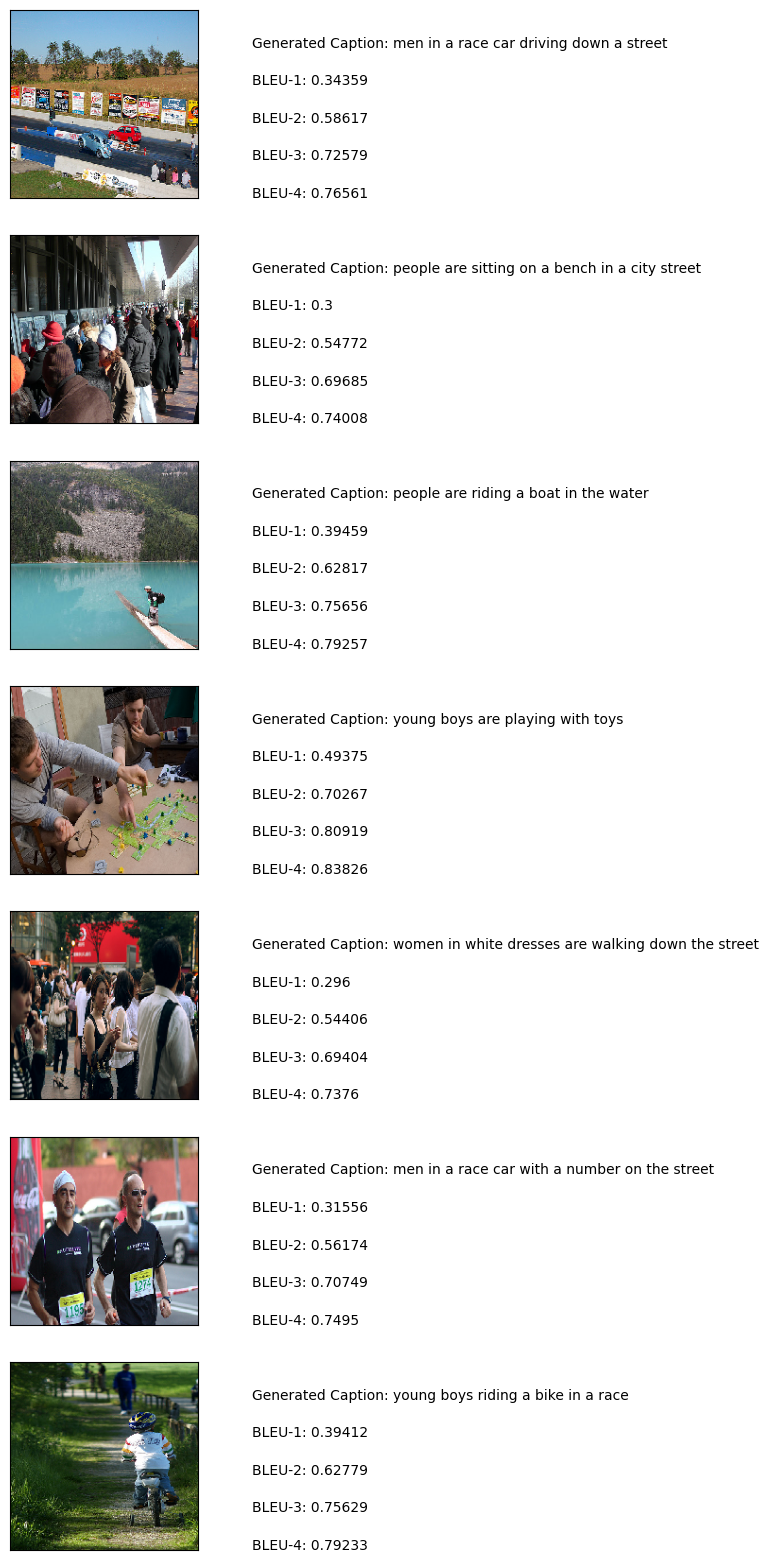

In [41]:
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys()) 
    images = [np.random.choice(keys) for i in range(num_of_images)] 
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("<start> ", "") for x in actual_cap]
        actual_cap = [x.replace(" <end>", "") for x in actual_cap] 
        
        caption = generated_captions[filename]
        caps_with_score = evaluator(actual_cap, [caption]*(len(actual_cap)))
    
        image_load = load_img(filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()
    
visualization(test_data, generated_captions, BLEU_score, 7)

In [40]:
sample_image = '/kaggle/input/sample1/flasj.jpg'

sample_cap = greedy_algorithm(sample_image)
sample_cap

'people are walking on a beach'